In [22]:
# import packages
import argparse, os, sys
from os import listdir
from os.path import isfile, join
import pickle
import math
import collections
import time

import numpy as np
import pandas as pd
import scanpy as sc
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import silhouette_score
from functools import partial

from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test

import anndata
from scipy.stats import spearmanr

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import gseapy as gp

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.sparse import csr_matrix
from statannotations.Annotator import Annotator
from scipy.stats import mannwhitneyu
import matplotlib.backends.backend_pdf
%matplotlib inline

In [23]:
# import x10 files and add metadata for annotation

# mCherry Low
low_veh_mCherry=sc.read_10x_mtx("/Users/moo4005/Desktop/Nature_paper_revision/scRNAseq/Low_Veh_mCherry/filtered_feature_bc_matrix",
                                var_names='gene_symbols',cache=True, gex_only=True)
low_veh_mCherry.obs['sample'] = "low_veh_mCherry"

low_cis_mCherry=sc.read_10x_mtx("/Users/moo4005/Desktop/Nature_paper_revision/scRNAseq/Low_Cis_mCherry/filtered_feature_bc_matrix",
                                var_names='gene_symbols',cache=True, gex_only=True)
low_cis_mCherry.obs['sample'] = "low_cis_mCherry"


# GFP Low
low_veh_GFP=sc.read_10x_mtx("/Users/moo4005/Desktop/Nature_paper_revision/scRNAseq/Low_Veh_GFP/filtered_feature_bc_matrix",
                                var_names='gene_symbols',cache=True, gex_only=True)
low_veh_GFP.obs['sample'] = "low_veh_GFP"

low_cis_GFP=sc.read_10x_mtx("/Users/moo4005/Desktop/Nature_paper_revision/scRNAseq/Low_Cis_GFP/filtered_feature_bc_matrix",
                                var_names='gene_symbols',cache=True, gex_only=True)
low_cis_GFP.obs['sample'] = "low_cis_GFP"

low_abe_GFP=sc.read_10x_mtx("/Users/moo4005/Desktop/Nature_paper_revision/scRNAseq/Low_Abe_GFP/filtered_feature_bc_matrix",
                                var_names='gene_symbols',cache=True, gex_only=True)
low_abe_GFP.obs['sample'] = "low_abe_GFP"


adata = anndata.concat([low_veh_GFP, low_abe_GFP ])


# and delete individual datasets to save space
del(low_veh_mCherry, low_cis_mCherry, 
                       low_veh_GFP, low_cis_GFP, 
                      )

print(adata.obs['sample'].value_counts())

low_veh_GFP    7918
low_abe_GFP    5256
Name: sample, dtype: int64


In [24]:
# Preprocessing
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

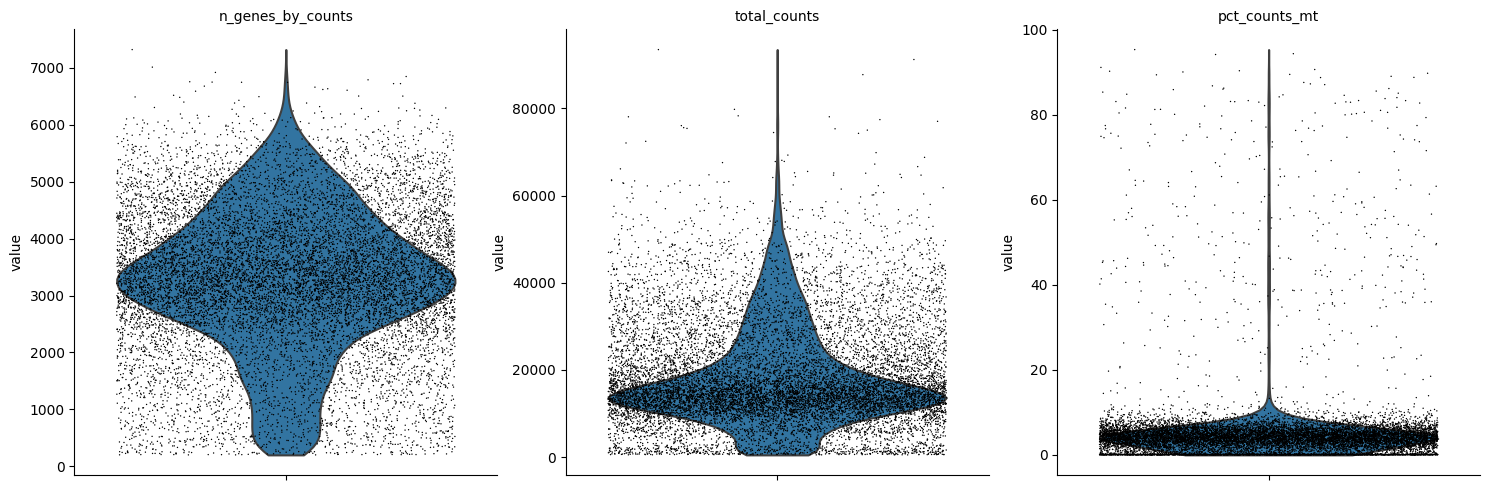

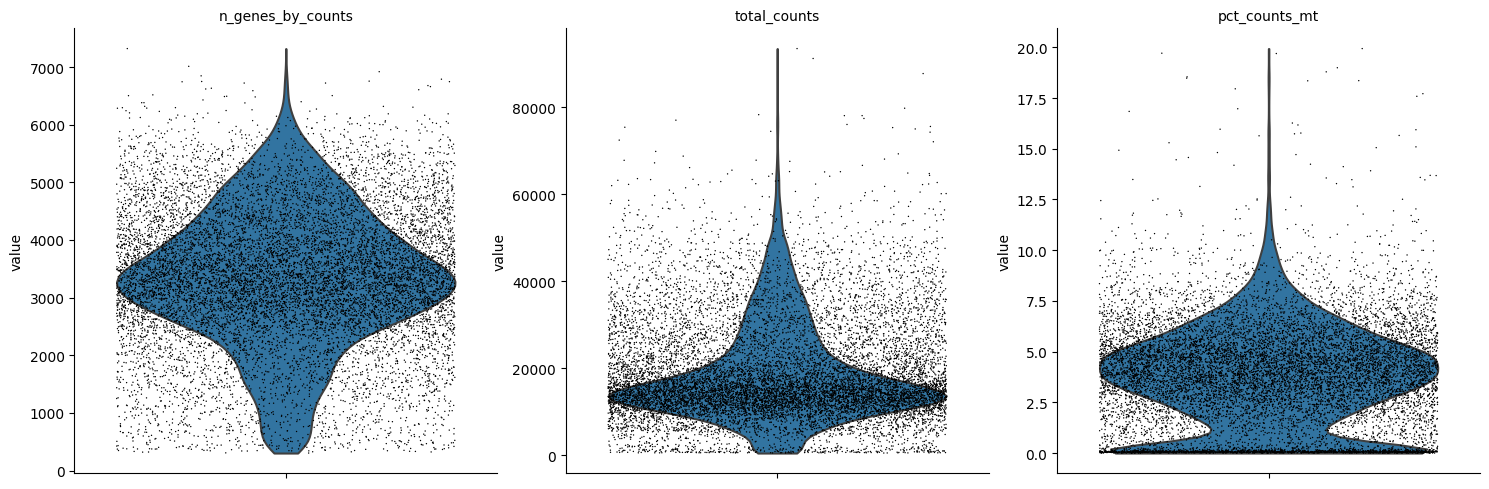

In [25]:
# filtering mitochondrial genes
adata.var['mt'] = adata.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

if not (adata.obs.pct_counts_mt == 0).all():
    adata = adata[adata.obs.pct_counts_mt < 20, :]


sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

In [26]:
sc.pp.normalize_total(adata, target_sum=1e4)
adata.raw = adata.copy()

In [27]:
sc.pp.log1p(adata)

In [28]:
print(adata.obs['sample'].value_counts())

low_veh_GFP    7602
low_abe_GFP    4746
Name: sample, dtype: int64


In [31]:
# Calculate differential expression between the two samples
sc.tl.rank_genes_groups(adata, groupby='sample', groups=['low_abe_GFP', 'low_veh_GFP'], reference='low_veh_GFP', method='t-test')

# Extract DE results
de_results = pd.DataFrame(adata.uns['rank_genes_groups']['names']).loc[:, 'low_abe_GFP']
de_scores = pd.DataFrame(adata.uns['rank_genes_groups']['scores']).loc[:, 'low_abe_GFP']

# Combine gene names and scores into a ranked list
ranked_list = pd.DataFrame({'gene_name': de_results, 'score': de_scores}).sort_values(by='score', ascending=False)
ranked_gene_list = ranked_list['gene_name'].tolist()

# get deg result
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
degs = pd.DataFrame(
    {group + '_' + key: result[key][group]
    for group in groups for key in ['names','scores', 'pvals','pvals_adj','logfoldchanges']})

#degs.to_csv("deg_cis.csv")

In [36]:
rnk = ranked_list[['gene_name', 'score']].copy()
rnk.set_index('gene_name', inplace=True)
gene_sets = ["GO_Cellular_Component_2023"]

# Run GSEA
gsea_results = gp.prerank(rnk=rnk, gene_sets=gene_sets, min_size=15, max_size=500, outdir='gsea_output', no_plot=False)

# View GSEA results
print(gsea_results.res2d.head())

gsea_results.res2d.to_csv("/Users/moo4005/Desktop/enrichment.csv")

2024-02-15 21:46:04,776 [WARNING] Duplicated values found in preranked stats: 0.02% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


      Name                                               Term        ES  \
0  prerank  GO_Cellular_Component_2023__Large Ribosomal Su...  0.762125   
1  prerank  GO_Cellular_Component_2023__Cytosolic Large Ri...  0.762125   
2  prerank  GO_Cellular_Component_2023__Cytosolic Small Ri...  0.754721   
3  prerank  GO_Cellular_Component_2023__Ribosome (GO:0005840)  0.698111   
4  prerank  GO_Cellular_Component_2023__Small Ribosomal Su...  0.741512   

        NES NOM p-val FDR q-val FWER p-val  Tag % Gene %  \
0  2.499289       0.0       0.0        0.0  35/49  2.96%   
1  2.499289       0.0       0.0        0.0  35/49  2.96%   
2  2.478306       0.0       0.0        0.0  25/36  1.40%   
3  2.442048       0.0       0.0        0.0  32/58  1.58%   
4  2.439148       0.0       0.0        0.0  25/37  1.40%   

                                          Lead_genes  
0  RPL32;UBA52;RPLP1;RPL14;RPL19;RPL30;RPL11;RPL2...  
1  RPL32;UBA52;RPLP1;RPL14;RPL19;RPL30;RPL11;RPL2...  
2  RPS27A;RPS13;UBA52;F

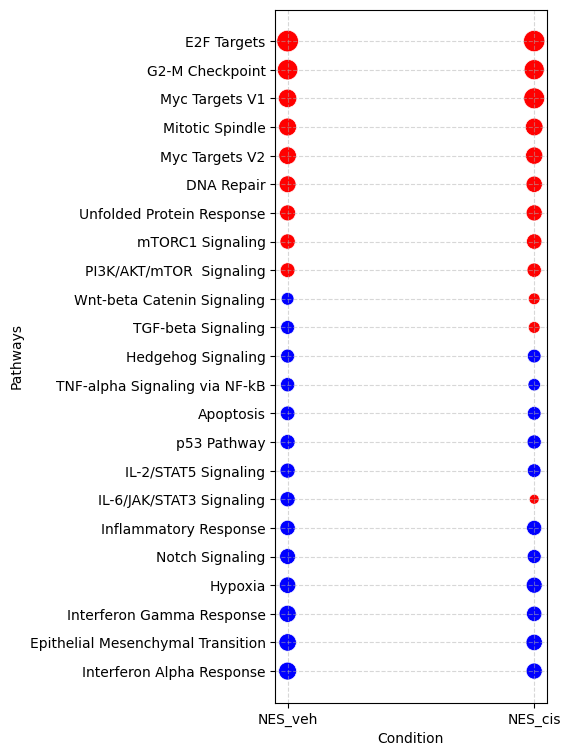

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the data
data = pd.read_csv("enrichment_scores_veh_cis.csv")

# Create a DataFrame from the data
df = pd.DataFrame(data)

# Plotting setup
fig, ax = plt.subplots(figsize=(3.5, 9))

# Time points to be plotted
time_points = ['NES_veh', 'NES_cis']

# Adjust the base scaling factor for bubble sizes (this factor directly scales the NES values for visualization)
base_scaling_factor = 70  # You might adjust this based on how the bubbles appear

# Plot each time point as a separate series
for i, time_point in enumerate(time_points):
    # Calculate x position for each time point series
    x_values = [i] * len(df)
    
    # Scale NES values for bubble sizes
    nes_size = np.abs(df[time_point]) * base_scaling_factor
    
    # Create scatter plot for each time point
    sc = ax.scatter(
        x_values,                # X-axis: positions for the current time point series
        df['Term'],              # Y-axis: pathways
        s=nes_size,              # Bubble size: NES value scaled by base_scaling_factor
        c=['red' if nes > 0 else 'blue' for nes in df[time_point]],  # Bubble color: red if NES > 0, blue if NES < 0
        alpha=1,                 # Transparency
        edgecolors='w',          # Bubble edge color
        linewidth=0.5,           # Bubble edge width
    )


# Add a grid
ax.grid(True, linestyle='--', alpha=0.5)

# Set axis labels
ax.set_xlabel('Condition')
ax.set_ylabel('Pathways')

# Set x-ticks to be the time points
ax.set_xticks(range(len(time_points)))
ax.set_xticklabels(time_points)

# Invert y-axis so that highest pathways are at the top
ax.invert_yaxis()

# Set the aspect of the plot to equal for better spacing
ax.set_aspect('auto')



#plt.savefig('enrichment_veh_cis.svg', format='svg')

# Show the plot
plt.show()


In [ ]:
1.02